In [356]:
import torch
import torch_geometric

import numpy as np
import networkx as nx
import osmnx as ox
from typing import NamedTuple
import random
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import json
import os
from tqdm import tqdm
from IPython.display import clear_output

METERS_IN_1_MILE = 1609
FEET_IN_1_METER = 3.28084

In [2]:
class BoundingBox(NamedTuple):
    north: float # lat
    east: float # lng
    south: float # lat
    west: float # lng

## Human defined bouding box(s)

In [3]:
wasatch = BoundingBox(40.871006, -111.441968, 40.445959, -111.977901) # big
pcmr = BoundingBox(40.710475, -111.440984,40.571173,-111.616881) # medium
bentonville = BoundingBox(36.5041, -94.0979, 36.2675, -94.3609) # medium
fayettville = BoundingBox(36.0698, -94.1638, 36.0177, -94.2285) # small-medium
sedona = BoundingBox(34.882, -111.7516, 34.8051, -111.8889) # medium
upper_sedona = BoundingBox(34.9067, -111.8121, 34.8597, -111.8643) # small
lower_sedona = BoundingBox(34.8547,-111.7862, 34.8288,-111.8328) # small
hog_sedona = BoundingBox(34.848, -111.7441, 34.8244, -111.7738) # small
round_valley = BoundingBox(40.7187, -111.4548, 40.6715, -111.514) # small
pine_canyon = BoundingBox(40.5702, -111.4239, 40.5235, -111.5198) # small-medium
corner_canyon = BoundingBox(40.5148, -111.7358, 40.4229, -111.917) # medium
milcreek_and_right = BoundingBox(40.7618, -111.5208, 40.6397, -111.7862) # medium
moab_upper = BoundingBox(38.7637,-109.5921, 38.5315,-109.8544) # medium
slickrock_area = BoundingBox(38.6170,-109.4762, 38.5757,-109.5593) # medium
st_george = BoundingBox(37.1631,-113.5372, 37.0587,-113.7003) # large
sun_valley = BoundingBox(43.7577,-114.2647, 43.6072, -114.4872) # large
bbox_areas = [wasatch, pcmr, bentonville, fayettville, sedona, 
              upper_sedona, lower_sedona, hog_sedona, round_valley, 
              pine_canyon, corner_canyon, milcreek_and_right, moab_upper, 
              slickrock_area, st_george, sun_valley]

## Random sub-bounding box

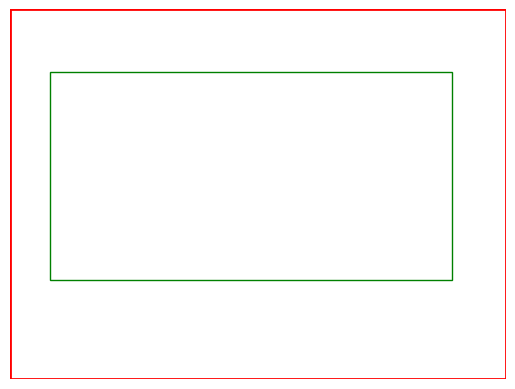

In [37]:
def random_bbox_within_bounding(bounding):
    bounding_width = bounding.east - bounding.west
    bounding_height = bounding.north - bounding.south

    one_mile_latlng = 1/60
    min_width = one_mile_latlng
    width = random.uniform(min_width, bounding_width)

    min_height = one_mile_latlng
    height = random.uniform(min_height, bounding_height)


    # choose where the width and heights starts (we have a rectangle, 
    # we need to choose where it fits within the bigger rectangle)
    random_south = random.uniform(bounding.south, bounding.north-height)
    random_north = random_south + height
    random_west = random.uniform(bounding.west, bounding.east-width)
    random_east = random_west + width

    return BoundingBox(random_north, random_east, random_south, random_west)

bounding = wasatch
bounding_width = bounding.east - bounding.west
bounding_height = bounding.north - bounding.south
random_subbox = random_bbox_within_bounding(bounding)


fig, ax = plt.subplots()
rect1 = patches.Rectangle((0, 0), bounding_width, bounding_height, linewidth=2, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((bounding.east-random_subbox.east, bounding.north-random_subbox.north),
                          random_subbox.east-random_subbox.west, random_subbox.north-random_subbox.south, 
                          linewidth=1, edgecolor='g', facecolor='none')

ax.set_xlim([0, bounding_width])
ax.set_ylim([0, bounding_height])
ax.set_axis_off()
ax.add_patch(rect1)
ax.add_patch(rect2)


## Graph from bbox

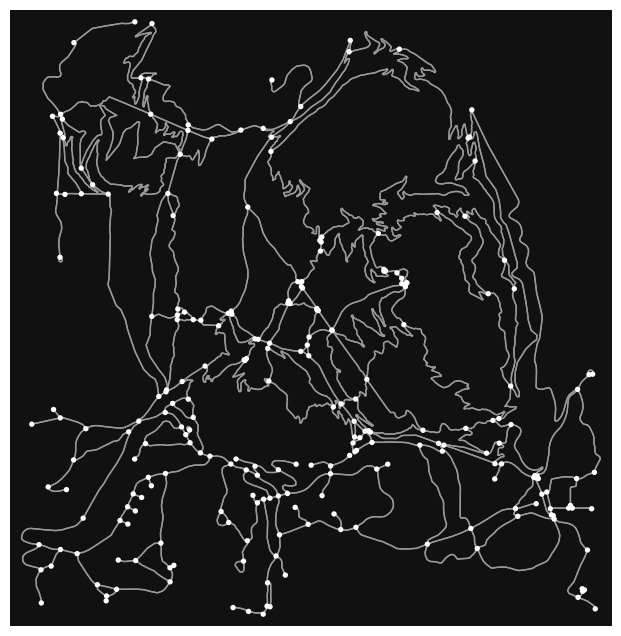

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [262]:
# for bbox_area in bbox_areas[-1:]:
bounding = round_valley
bbox = random_bbox_within_bounding(bounding)
ox.settings.useful_tags_way = ['highway', 'surface', 'name']
custom_filter = '["highway"]["area"!~"yes"]\
                ["highway"!~"service|abandoned|bus_guideway\
                 |construction|corridor|elevator|escalator|\
                 footway|motor|no|planned|platform|proposed|raceway|razed|steps"]\
                ["bicycle"!~"no"]["service"!~"private"]["informal"!~"yes"]["access"!="private"]'
G = ox.graph_from_bbox(bbox.north, bbox.south, bbox.east, bbox.west, custom_filter=custom_filter)

ox.plot_graph(G)

## Process into data

In [263]:
def cleanup_graph(G):
    for edge in G.edges:
        edge_data = G.edges[edge]
        if 'name' not in edge_data.keys():
            G.edges[edge]['name'] = 'Unknown'
        if 'highway' not in edge_data.keys():
            G.edges[edge]['highway'] = 'Unknown'
        if 'surface' not in edge_data.keys():
            G.edges[edge]['surface'] = 'Unknown'

def cleanup_merged_edges(G):
    for edge in G.edges:
        edge_data = G.edges[edge]
        if isinstance(edge_data['name'], list):
            name = ' & '.join(edge_data['name'])
            G.edges[edge]['name'] = name
        if isinstance(edge_data['highway'], list):
            highway = edge_data['highway'][0]
            G.edges[edge]['highway'] = highway
        if isinstance(edge_data['surface'], list):
            surface = edge_data['surface'][0]
            G.edges[edge]['surface'] = surface
    
def add_node_elevations(G):
    latlongs = []
    for node in G.nodes(data=True):
        latlongs.append(f'{node[1]["y"]},{node[1]["x"]}')
    body = '|'.join(latlongs)

    url = f'http://localhost:5001/v1/srtm30m_geotiff?locations={body}'
    response = requests.get(url).json()

    if 'error' in response:
        raise Exception("API Error")

    elevations = []
    for result in response['results']:
        elevation = result['elevation'] * FEET_IN_1_METER
        elevations.append(elevation)

    for node, elevation in zip(G.nodes, elevations):
        G.nodes[node]['elevation'] = elevation
        
def add_edge_surface_types(G):
    for edge in G.edges:
        edge_data = G.edges[edge]
        
        surface_type = None
        s = edge_data['surface'].lower()
        h = edge_data['highway'].lower()
        if  h=='path' or s=='rock' or s=='ground' or s=='dirt' or s=='earth' or s=='grass' or s=='mud' or s=='sand':
            surface_type = 2
        elif h=='track' or s=='gravel' or s=='unhewn_cobblestone' or s=='cobblestone' or s=='wood' or s=='unpaved' or s=='compacted' or s=='fine_gravel' or s=='gravel':
            surface_type = 1
        elif (h!='path' and h!='track') or s=='paved' or s=='asphalt' or s=='chipseal' or s=='concrete' or s=='paving_stones' or s=='sett':
            surface_type = 0
        else:
            print(f'Unknown Surface Type: {s=}, {h=}')
        
        G.edges[edge]['surface_type'] = surface_type
        G.edges[edge]['is_not_motor_road'] = int(h == 'path' or h == 'track')
        
def adjust_edge_lengths(G):
    for edge in G.edges:
        edge_data = G.edges[edge]
        length = edge_data['length']
        G.edges[edge]['length'] = length / METERS_IN_1_MILE
    
cleanup_graph(G)
cleanup_merged_edges(G)
# adjusting lengths needs to precede grade
adjust_edge_lengths(G)
# elevations needs to precede grades
add_node_elevations(G)
ox.add_edge_grades(G)
add_edge_surface_types(G)
   

In [293]:
# Remove unneccesary attributes and add any additional ones
def cleanup_node_attributes(G):
    new_attrs = {
        'is_start_node': 0,
        'is_end_node': 0,
        'is_in_route': 0,
        'is_current_node': 0
    }
    G.add_nodes_from(G.nodes, **new_attrs)

    for node in G.nodes:
        node_data = G.nodes[node]

        to_delete = []
        for attr, value in node_data.items():
            if attr not in new_attrs.keys():
                to_delete.append(attr)
        for attr in to_delete:
            del G.nodes[node][attr]

def cleanup_edge_attributes(G):
    attrs_to_keep = ['length', 'surface_type', 'grade_abs']
    for edge in G.edges:
        edge_data = G.edges[edge]

        to_delete = []
        for attr, value in edge_data.items():
            if attr not in attrs_to_keep:
                to_delete.append(attr)
        for attr in to_delete:
            del G.edges[edge][attr]
            
def choose_random_start_and_end_nodes(G):
    num_nodes = len(G.nodes)
    start = np.random.randint(0, num_nodes)
    end = np.random.randint(0, num_nodes)
    while end == start:
        end = np.random.randint(0, num_nodes)
    
    G.nodes[list(G.nodes)[start]]['is_start_node'] = 1
    G.nodes[list(G.nodes)[start]]['is_current_node'] = 1
    G.nodes[list(G.nodes)[start]]['is_in_route'] = 1
    G.nodes[list(G.nodes)[end]]['is_end_node'] = 1
    
  
cleanup_node_attributes(G)
cleanup_edge_attributes(G)
choose_random_start_and_end_nodes(G)

In [294]:
pyg_graph = torch_geometric.utils.convert.from_networkx(G, 
                                                        group_node_attrs=['is_start_node', 'is_end_node', 'is_in_route', 'is_current_node'],
                                                        group_edge_attrs=['length', 'surface_type', 'grade_abs'])

## Set user preferences to random values

In [347]:
length_index = 0
graph_length = sum(pyg_graph.edge_attr[:, length_index])

user_preferences = {
    'overall_distance': np.random.uniform(0, graph_length),
    'steepnesss': np.random.randint(0, 100),
    'surface_roughness': np.random.randint(0, 100),
}

pyg_graph.y = torch.tensor(list(user_preferences.values()))

## Putting it all together and saving

In [359]:

def generate_dataset(num_examples, num_examples_per_graph):
    idx = 0
    print(idx)
    for _ in range(num_examples):
        bounding = random.choice(bbox_areas)
        bbox = random_bbox_within_bounding(bounding)
        ox.settings.useful_tags_way = ['highway', 'surface', 'name']
        custom_filter = '["highway"]["area"!~"yes"]\
                        ["highway"!~"service|abandoned|bus_guideway\
                         |construction|corridor|elevator|escalator|\
                         footway|motor|no|planned|platform|proposed|raceway|razed|steps"]\
                        ["bicycle"!~"no"]["service"!~"private"]["informal"!~"yes"]["access"!="private"]'
        G = ox.graph_from_bbox(bbox.north, bbox.south, bbox.east, bbox.west, custom_filter=custom_filter)
        
        # processing
        cleanup_graph(G)
        cleanup_merged_edges(G)
        adjust_edge_lengths(G)
        add_node_elevations(G)
        ox.add_edge_grades(G)
        add_edge_surface_types(G)
        cleanup_node_attributes(G)
        cleanup_edge_attributes(G)
        choose_random_start_and_end_nodes(G)
        
        pyg_graph = torch_geometric.utils.convert.from_networkx(G, 
                                group_node_attrs=['is_start_node', 'is_end_node', 'is_in_route', 'is_current_node'],
                                group_edge_attrs=['length', 'surface_type', 'grade_abs'])
        length_index = 0
        graph_length = sum(pyg_graph.edge_attr[:, length_index])
        
        for i in range(num_examples_per_graph):
            user_preferences = {
                'overall_distance': np.random.uniform(0, graph_length),
                'steepnesss': np.random.randint(0, 100),
                'surface_roughness': np.random.randint(0, 100),
            }
            pyg_graph.y = torch.tensor(list(user_preferences.values()))
            torch.save(pyg_graph, os.path.join('data', f'data_{idx}.pt'))
            idx+=1
            clear_output(wait=True)
            print(idx)
        
num_examples = 10_000
num_examples_per_graph = 10
generate_dataset(num_examples, num_examples_per_graph)

80


KeyboardInterrupt: 